In [ ]:
pip install langchain-groq langchain-huggingface langchain-chroma langchain-community langgraph arxiv pymupdf sentence_transformers chromadb tiktoken

In [4]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [6]:
from typing import TypedDict, List, Optional, Literal

class MultiExpertState(TypedDict):
    query: str
    domain: Optional[str]
    retrieved_docs: Optional[List[str]]
    final_answer: Optional[str]
    expert_used: Optional[str]

In [8]:
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader

web_loader = WebBaseLoader("https://python.langchain.com/docs/tutorials/rag/")
tech_docs = web_loader.load()

arxiv_loader = ArxivLoader(query="large language models", load_max_docs=3)
sci_docs = arxiv_loader.load()

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
tech_chunks = text_splitter.split_documents(tech_docs)
sci_chunks = text_splitter.split_documents(sci_docs)

In [10]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
from langchain_chroma import Chroma

tech_vectorstore = Chroma.from_documents(
    tech_chunks,
    embeddings,
    collection_name="tech_docs"
)

sci_vectorstore = Chroma.from_documents(
    sci_chunks,
    embeddings,
    collection_name="sci_papers"
)

tech_retriever = tech_vectorstore.as_retriever(search_kwargs={"k": 3})
sci_retriever = sci_vectorstore.as_retriever(search_kwargs={"k": 3})

In [12]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="openai/gpt-oss-120b", temperature=0)

In [13]:
from langgraph.types import Command
def router_agent(state: MultiExpertState) -> Command[Literal["tech_expert", "sci_expert"]]:
    """Routes queries to appropriate expert based on keywords"""
    query = state["query"].lower()

    # Simple keyword-based routing
    sci_keywords = ["research", "paper", "study", "neural", "model", "algorithm", "arxiv"]
    tech_keywords = ["langchain", "rag", "tutorial", "code", "implementation", "documentation"]

    if any(keyword in query for keyword in sci_keywords):
        domain = "science"
        next_node = "sci_expert"
    else:
        domain = "technical"
        next_node = "tech_expert"

    return Command(
        update={"domain": domain},
        goto=next_node
    )

In [14]:
def tech_expert(state: MultiExpertState) -> Command[Literal["generate_answer"]]:
    """Technical documentation expert"""
    query = state["query"]

    # Retrieve relevant documents
    docs = tech_retriever.invoke(query)
    doc_texts = [doc.page_content for doc in docs]

    return Command(
        update={
            "retrieved_docs": doc_texts,
            "expert_used": "Technical Documentation Expert"
        },
        goto="generate_answer"
    )

In [15]:
def sci_expert(state: MultiExpertState) -> Command[Literal["generate_answer"]]:
    """Scientific papers expert"""
    query = state["query"]

    # Retrieve relevant documents
    docs = sci_retriever.invoke(query)
    doc_texts = [doc.page_content for doc in docs]

    return Command(
        update={
            "retrieved_docs": doc_texts,
            "expert_used": "Scientific Research Expert"
        },
        goto="generate_answer"
    )

In [16]:
def generate_answer(state: MultiExpertState) -> Command[Literal["__end__"]]:
    """Generate final answer using retrieved documents"""
    query = state["query"]
    docs = state["retrieved_docs"]
    expert = state["expert_used"]

    # Create context from retrieved documents
    context = "\n\n".join(docs[:3])  # Use top 3 documents

    prompt = f"""You are the {expert}. Answer the following question based on the provided context.

Context:
{context}

Question: {query}

Answer:"""

    response = llm.invoke(prompt)

    return Command(
        update={"final_answer": response.content},
        goto="__end__"
    )

In [17]:
from langgraph.graph import StateGraph, START, END

# Create the StateGraph
workflow = StateGraph(MultiExpertState)

# Add nodes
workflow.add_node("router", router_agent)
workflow.add_node("tech_expert", tech_expert)
workflow.add_node("sci_expert", sci_expert)
workflow.add_node("generate_answer", generate_answer)

# Set entry point
workflow.add_edge(START, "router")

# Compile the graph
app = workflow.compile()

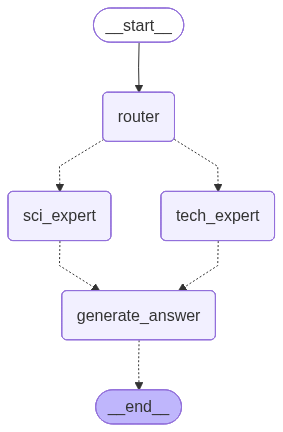

In [18]:
app

In [20]:
print("=== Testing Technical Query ===")
tech_query = "How do I build a RAG application with LangChain?"
result1 = app.invoke({"query": tech_query})

print(f"Query: {tech_query}")
print(f"Domain: {result1['domain']}")
print(f"Expert Used: {result1['expert_used']}")
print(f"Answer: {result1['final_answer']}...")
print()

=== Testing Technical Query ===
Query: How do I build a RAG application with LangChain?
Domain: technical
Expert Used: Technical Documentation Expert
Answer: ## Building a Retrieval‑Augmented Generation (RAG) App with LangChain  
Below is a **step‑by‑step guide** that takes you from a fresh environment to a fully‑working RAG pipeline, using the three core LangChain components you’ll need:

| Component | What it does | Typical LangChain class |
|-----------|--------------|--------------------------|
| **Text splitter** | Breaks raw documents into manageable chunks (e.g., 1 000‑token pieces) | `RecursiveCharacterTextSplitter` (or any splitter from `langchain_text_splitters`) |
| **Embedding model** | Turns each chunk into a dense vector for similarity search | `OpenAIEmbeddings`, `HuggingFaceEmbeddings`, etc. |
| **Vector store / Retriever** | Persists the vectors and provides fast “nearest‑neighbors” look‑up | `FAISS`, `Chroma`, `Pinecone`, `Weaviate`, … (any class that implements `Vect

In [21]:
print("=== Testing Scientific Query ===")
sci_query = "What are the latest developments in large language models research?"
result2 = app.invoke({"query": sci_query})

print(f"Query: {sci_query}")
print(f"Domain: {result2['domain']}")
print(f"Expert Used: {result2['expert_used']}")
print(f"Answer: {result2['final_answer']}...")

=== Testing Scientific Query ===
Query: What are the latest developments in large language models research?
Domain: science
Expert Used: Scientific Research Expert
Answer: **Latest Developments in Large‑Language‑Model (LLM) Research (as reflected in the provided context)**  

| Area | What’s new / emerging | Why it matters |
|------|----------------------|----------------|
| **Open, multilingual LLMs** | • **BLOOM** – a 176‑billion‑parameter model released openly, trained on the **ROOTs** dataset (≈1.6 TB of multilingual text). <br>• **Meta’s XLM‑RoBERTa** (trained on 100 languages) and **Google’s mBERT** (trained on 104 languages) continue to be refined and benchmarked. | Makes state‑of‑the‑art capabilities available beyond English, encourages community‑wide reproducibility, and provides a test‑bed for cross‑lingual research. |
| **Public, well‑documented training data** | The **ROOTs** corpus is fully documented and publicly released, allowing researchers to audit, analyze, and exten